# Tensorflow Tutorial - RNN

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time

print(tf.__version__)

2.8.2


In [ ]:
# RNN 예시
inputs = np.random.random([32, 10, 8]).astype(np.float32)

rnn = tf.keras.layers.RNN(
    tf.keras.layers.SimpleRNNCell(4),
    return_sequences=True,
    return_state=True)

# whole_sequence_output has shape `[32, 10, 4]`.
# final_state has shape `[32, 4]`.
whole_sequence_output, final_state = rnn(inputs)
print(whole_sequence_output.shape)
print(final_state.shape)

(32, 10, 4)
(32, 4)


In [ ]:
# LSTM 예시
inputs = tf.random.normal([32, 10, 8])

rnn = tf.keras.layers.RNN(
   tf.keras.layers.LSTMCell(4),
   return_sequences=True,
   return_state=True)
whole_seq_output, final_memory_state, final_carry_state = rnn(inputs)

print(whole_seq_output.shape)
print(final_memory_state.shape)
print(final_carry_state.shape)

(32, 10, 4)
(32, 4)
(32, 4)


# 순환 신경망을 활용한 문자열 생성

## 셰익스피어 데이터셋 다운로드

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1130496/1115394 [==============================] - 0s 0us/step


# 텍스트 읽기

In [ ]:
# 읽은 다음 파이썬 2와 호환되도록 디코딩합니다.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# 텍스트의 길이는 그 안에 있는 문자의 수입니다.
print ('텍스트의 길이: {}자'.format(len(text)))

텍스트의 길이: 1115394자


In [ ]:
# 텍스트의 처음 250자를 살펴봅니다
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# 파일의 고유 문자수를 출력합니다.
vocab = sorted(set(text))
print ('고유 문자수 {}개'.format(len(vocab)))

고유 문자수 65개


# 텍스트 처리
## 텍스트 벡터화
- 훈련 전 문자들을 수치화하는 과정
- 하나는 문자를 숫자에 매핑하고 다른 하나는 숫자를 문자에 매핑하는 것

In [ ]:
# 고유 문자에서 인덱스로 매핑 생성
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [ ]:
# 각 문자에 대한 정수 표현을 만듦
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [ ]:
# 텍스트에서 처음 13개의 문자가 숫자로 어떻게 매핑되었는지를 보여줍니다
print ('{} ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- 문자들이 다음의 정수로 매핑되었습니다 ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


# 훈련 샘플과 타깃 만들기
- 각 입력 시퀀스에는 텍스트에서 나온 seq_length개의 문자가 포함
- 각 입력 시퀀스에서, 해당 타깃은 한 문자를 오른쪽으로 이동한 것을 제외하고는 동일한 길이의 텍스트를 포함
- 따라서 각 텍스트를 seq_length + 1의 청크로 나눔

In [ ]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text)//seq_length

# 훈련 샘플/타깃 만들기
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

F
i
r
s
t


In [ ]:
# batch 메소드를 사용해서 개별 문자들을 원하는 크기의 시퀀스로 변환
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
# map 메서드를 사용해서 각 배치에 간단한 함수를 적용하고 입력 텍스트와 타깃 텍스트를 복사 및 이동
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# 첫 번째 샘플과 타깃 값 출력
for input_example, target_example in  dataset.take(1):
  print ('입력 데이터: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('타깃 데이터: ', repr(''.join(idx2char[target_example.numpy()])))

입력 데이터:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
타깃 데이터:  'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("{:4d}단계".format(i))
    print("  입력: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  예상 출력: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

   0단계
  입력: 18 ('F')
  예상 출력: 47 ('i')
   1단계
  입력: 47 ('i')
  예상 출력: 56 ('r')
   2단계
  입력: 56 ('r')
  예상 출력: 57 ('s')
   3단계
  입력: 57 ('s')
  예상 출력: 58 ('t')
   4단계
  입력: 58 ('t')
  예상 출력: 1 (' ')


훈련 배치 생성

In [ ]:
# 배치 크기
BATCH_SIZE = 64

# 데이터셋을 섞을 버퍼 크기
# (TF 데이터는 무한한 시퀀스와 함께 작동이 가능하도록 설계되었으며,
# 따라서 전체 시퀀스를 메모리에 섞지 않습니다. 대신에,
# 요소를 섞는 버퍼를 유지합니다).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# 모델 설계
- tf.keras.layers.Embedding : 입력층. embedding_dim 차원 벡터에 각 문자의 정수 코드를 매핑하는 훈련 가능한 검색 테이블.
- tf.keras.layers.LSTM : 크기가 units = rnn_units인 RNN의 유형
- tf.keras.layers.Dense : 크기가 vocab_size인 출력을 생성하는 출력층.

In [ ]:
# 문자로 된 어휘 사전의 크기
vocab_size = len(vocab)

# 임베딩 차원
embedding_dim = 256

# RNN 유닛(unit) 개수
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [ ]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (배치 크기, 시퀀스 길이, 어휘 사전 크기)")

(64, 100, 65) # (배치 크기, 시퀀스 길이, 어휘 사전 크기)


In [ ]:
from IPython.display import Image
Image('lstm2.png')

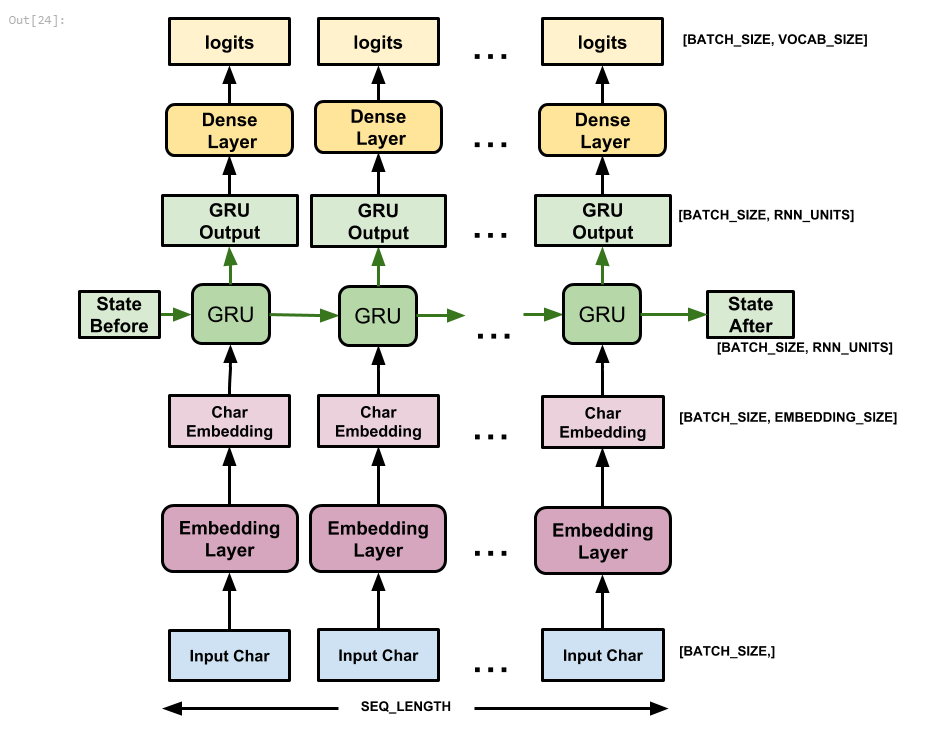

모델 사용

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           16640     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 배치의 첫 번째 샘플링
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([48, 30,  2, 30, 50, 26,  9, 21,  0, 53, 46, 16, 42, 37, 56, 33, 29,
       30,  5, 14, 48, 27, 52, 38, 61, 31, 62,  1, 60, 31,  4,  2, 30, 11,
       45, 46, 62, 20,  8, 48, 11, 13, 11, 61, 33, 54, 22, 22, 11, 28, 30,
       56, 30, 26, 49,  4,  1, 27, 31, 23, 34, 52, 39, 49,  7, 43, 59, 13,
       35, 20, 18, 58,  2, 45, 23, 27, 46, 22, 14, 24, 25, 24, 59, 11, 23,
       15, 53, 32, 44, 63, 40, 24, 37, 17, 57,  9, 25, 56, 55,  9])

In [ ]:
# 훈련되지 않은 모델에 의해 예측된 텍스트
print("입력: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("예측된 다음 문자: \n", repr("".join(idx2char[sampled_indices ])))

입력: 
 'live in Scotland a forlorn;\nWhile proud ambitious Edward Duke of York\nUsurps the regal title and the'

예측된 다음 문자: 
 "jR!RlN3I\nohDdYrUQR'BjOnZwSx vS&!R;ghxH.j;A;wUpJJ;PRrRNk& OSKVnak-euAWHFt!gKOhJBLMLu;KCoTfybLYEs3Mrq3"


# 모델 훈련

In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("예측 배열 크기(shape): ", example_batch_predictions.shape, " # (배치 크기, 시퀀스 길이, 어휘 사전 크기")
print("스칼라 손실:          ", example_batch_loss.numpy().mean())

예측 배열 크기(shape):  (64, 100, 65)  # (배치 크기, 시퀀스 길이, 어휘 사전 크기
스칼라 손실:           4.1732793


In [ ]:
model.compile(optimizer='adam', loss=loss)

# 체크 포인트 구성
- tf.keras.callbacks.ModelCheckpoint를 사용해서 훈련 중 체크포인트가 저장되도록 함

In [ ]:
# 체크포인트가 저장될 디렉토리
checkpoint_dir = './training_checkpoints'
# 체크포인트 파일 이름
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# 훈련 실행

In [ ]:
EPOCHS=10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 1201s 7s/step - loss: 2.5775
Epoch 2/10
 86/172 [==============>...............] - ETA: 9:52 - loss: 1.9588

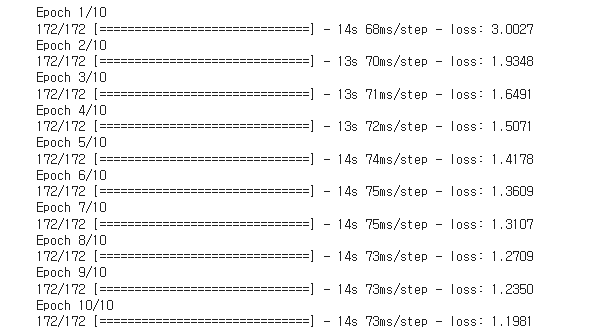

##텍스트 생성
##최근 체크포인트 복원

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

image.png

In [ ]:
# 예측 단계를 간단하게 유지하기 위해서 배치 크기를 1로 설정
# 다른 배치크기로 모델을 실행하려면 모델을 다시 빌드하고 체크포인트에서 가중치를 복원
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

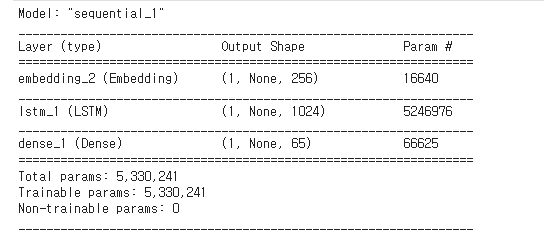

 # 예측 루프

In [ ]:
def generate_text(model, start_string):
  # 평가 단계 (학습된 모델을 사용하여 텍스트 생성)

  # 생성할 문자의 수
  num_generate = 1000

  # 시작 문자열을 숫자로 변환(벡터화)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # 결과를 저장할 빈 문자열
  text_generated = []

  # 온도가 낮으면 더 예측 가능한 텍스트가 됩니다.
  # 온도가 높으면 더 의외의 텍스트가 됩니다.
  # 최적의 세팅을 찾기 위한 실험
  temperature = 1.0

  # 여기에서 배치 크기 == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # 배치 차원 제거
      predictions = tf.squeeze(predictions, 0)

      # 범주형 분포를 사용하여 모델에서 리턴한 단어 예측
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # 예측된 단어를 다음 입력으로 모델에 전달
      # 이전 은닉 상태와 함께
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"ROMEO: "))

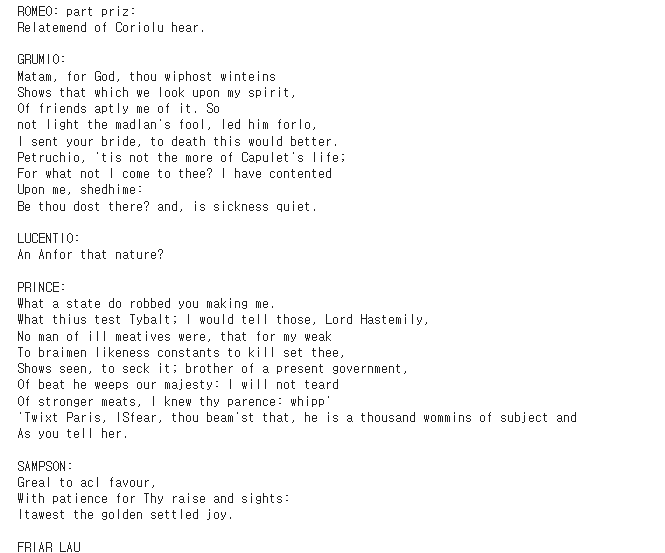

# => 10번의 epoch를 통해 단어와 영어를 꽤 잘 가져왔으며, 텍스트 형태도 잘 가져왔다.